## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 29 columns):
EVENT_ID              4802 non-null int64
INJURIES_DIRECT       4802 non-null int64
DEATHS_DIRECT         4802 non-null int64
DAMAGE_PROPERTY       4802 non-null float64
DAMAGE_CROPS          4802 non-null float64
DURATION_SECONDS      4802 non-null float64
BEGIN_LAT             4802 non-null float64
BEGIN_LON             4802 non-null float64
TOR_LENGTH            4802 non-null float64
TOR_WIDTH             4802 non-null float64
BEGIN_DATE_TIME       4802 non-null float64
YEAR                  4802 non-null int64
CZ_NAME               4802 non-null object
STATE                 4802 non-null object
OPEN_WATER_PROP       4802 non-null float64
DEV_OPEN_PROP         4802 non-null float64
DEV_LOW_PROP          4802 non-null float64
DEV_MED_PROP          4802 non-null float64
DEV_HIGH_PROP         4802 non-null float64
DECID_FOREST_PROP     4802 non-null float64
EVERGR_FOREST_PROP    4

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [3]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 1 columns):
DAMAGE_PROPERTY    4802 non-null float64
dtypes: float64(1)
memory usage: 37.6 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 5:]


# Get rid of year and county name
tornado_features = tornado_features.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)



# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 21 columns):
DURATION_SECONDS      4802 non-null float64
BEGIN_LAT             4802 non-null float64
BEGIN_LON             4802 non-null float64
TOR_LENGTH            4802 non-null float64
TOR_WIDTH             4802 non-null float64
BEGIN_DATE_TIME       4802 non-null float64
OPEN_WATER_PROP       4802 non-null float64
DEV_OPEN_PROP         4802 non-null float64
DEV_LOW_PROP          4802 non-null float64
DEV_MED_PROP          4802 non-null float64
DEV_HIGH_PROP         4802 non-null float64
DECID_FOREST_PROP     4802 non-null float64
EVERGR_FOREST_PROP    4802 non-null float64
MIXED_FOREST_PROP     4802 non-null float64
SHRUB_SCRUB_PROP      4802 non-null float64
GRASS_LAND_PROP       4802 non-null float64
PASTURE_HAY_PROP      4802 non-null float64
CULT_CROPS_PROP       4802 non-null float64
WOOD_WETLAND_PROP     4802 non-null float64
HERB_WETLAND_PROP     4802 non-null float64
BARREN_LAND_P

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.8255
 0.9146
 0.5951
   ⋮    
 0.7866
 0.9965
 0.3145
[torch.DoubleTensor of size 4802x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


-3.7344e-01 -1.3407e+00  8.8918e-01  ...   1.0674e+00  1.0701e+00  1.9281e+00
 3.4596e-01 -9.7073e-01  7.7545e-01  ...   9.1851e-01 -2.7522e-01  1.6105e+00
-1.4814e-02 -1.1268e+00  7.1611e-01  ...   1.2650e+00  1.0381e+00 -6.9525e-01
                ...                   ⋱                   ...                
 1.3037e+00 -5.6718e-01  9.9362e-01  ...  -2.6493e-01 -9.0635e-01  3.3708e-01
 9.6160e-01  3.2339e-01  5.4406e-01  ...   4.0468e-01 -9.0635e-01 -6.9525e-01
 1.3037e+00 -6.9357e-02 -8.9707e-01  ...  -2.6485e-01 -9.0635e-01 -6.9525e-01
[torch.DoubleTensor of size 4802x21]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


-3.7344e-01 -1.3407e+00  8.8918e-01  ...   1.0674e+00  1.0701e+00  1.9281e+00
 3.4596e-01 -9.7073e-01  7.7545e-01  ...   9.1851e-01 -2.7522e-01  1.6105e+00
-1.4814e-02 -1.1268e+00  7.1611e-01  ...   1.2650e+00  1.0381e+00 -6.9525e-01
                ...                   ⋱                   ...                
 1.3037e+00 -5.6718e-01  9.9362e-01  ...  -2.6493e-01 -9.0635e-01  3.3708e-01
 9.6160e-01  3.2339e-01  5.4406e-01  ...   4.0468e-01 -9.0635e-01 -6.9525e-01
 1.3037e+00 -6.9357e-02 -8.9707e-01  ...  -2.6485e-01 -9.0635e-01 -6.9525e-01
[torch.FloatTensor of size 4802x21]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

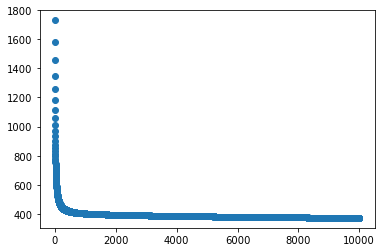

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4802)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(4802)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

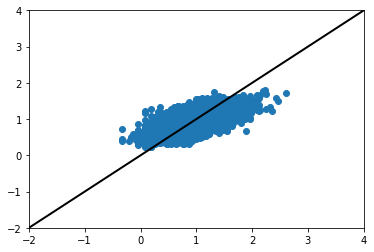

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 5:]

valid_predictors = valid_predictors.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight

In [20]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 809.9252
[torch.FloatTensor of size 1]

In [21]:
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 21 columns):
DURATION_SECONDS      1571 non-null float64
BEGIN_LAT             1571 non-null float64
BEGIN_LON             1571 non-null float64
TOR_LENGTH            1571 non-null float64
TOR_WIDTH             1571 non-null float64
BEGIN_DATE_TIME       1571 non-null float64
OPEN_WATER_PROP       1571 non-null float64
DEV_OPEN_PROP         1571 non-null float64
DEV_LOW_PROP          1571 non-null float64
DEV_MED_PROP          1571 non-null float64
DEV_HIGH_PROP         1571 non-null float64
DECID_FOREST_PROP     1571 non-null float64
EVERGR_FOREST_PROP    1571 non-null float64
MIXED_FOREST_PROP     1571 non-null float64
SHRUB_SCRUB_PROP      1571 non-null float64
GRASS_LAND_PROP       1571 non-null float64
PASTURE_HAY_PROP      1571 non-null float64
CULT_CROPS_PROP       1571 non-null float64
WOOD_WETLAND_PROP     1571 non-null float64
HERB_WETLAND_PROP     1571 non-null float64
BARREN_LAND_P

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1571)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [23]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(1571)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

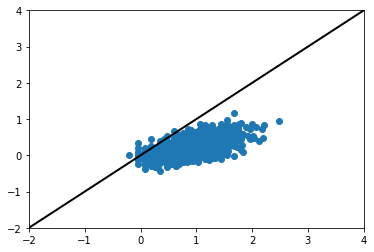

In [24]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.2: The Model Above has Proven Best; Final Plot against Test Data

In [25]:
# Import data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set_no_zeros.csv")


# Validation set outcomes
test_outcomes = test_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
test_outcomes_array = test_outcomes.values


# Makes the numpy array into a torch Tensor
test_outcomes_Tensor = torch.from_numpy(test_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
test_outcomes_Tensor = test_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_outcomes_Variable = Variable(test_outcomes_Tensor)

In [26]:
# Validation set predictors
test_predictors = test_df.iloc[:, 5:]

test_predictors = test_predictors.drop(["YEAR",
                                        "CZ_NAME",
                                        "STATE"],
                                       axis = 1)


# Make the validation predictors into a numpy array
test_predictors_array = test_predictors.values


# Makes the numpy array into a torch Tensor
test_predictors_Tensor = torch.from_numpy(test_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
test_predictors_Tensor = test_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_predictors_Variable = Variable(test_predictors_Tensor)

In [27]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight

In [28]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 673.0477
[torch.FloatTensor of size 1]

In [29]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 21 columns):
DURATION_SECONDS      1587 non-null float64
BEGIN_LAT             1587 non-null float64
BEGIN_LON             1587 non-null float64
TOR_LENGTH            1587 non-null float64
TOR_WIDTH             1587 non-null float64
BEGIN_DATE_TIME       1587 non-null float64
OPEN_WATER_PROP       1587 non-null float64
DEV_OPEN_PROP         1587 non-null float64
DEV_LOW_PROP          1587 non-null float64
DEV_MED_PROP          1587 non-null float64
DEV_HIGH_PROP         1587 non-null float64
DECID_FOREST_PROP     1587 non-null float64
EVERGR_FOREST_PROP    1587 non-null float64
MIXED_FOREST_PROP     1587 non-null float64
SHRUB_SCRUB_PROP      1587 non-null float64
GRASS_LAND_PROP       1587 non-null float64
PASTURE_HAY_PROP      1587 non-null float64
CULT_CROPS_PROP       1587 non-null float64
WOOD_WETLAND_PROP     1587 non-null float64
HERB_WETLAND_PROP     1587 non-null float64
BARREN_LAND_P

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1587)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

In [31]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
test_outcomes_Variable_resized = test_outcomes_Variable.resize(1587)


# Make the FloatTensor into a numpy.array
test_outcomes_array = test_outcomes_Variable_resized.data.numpy()


# Convert back to native units and scale
test_outcomes_array = test_outcomes_array*5.735285 + 6.490682


# Make the numpy.array into a list
test_outcomes_list = test_outcomes_array.tolist()

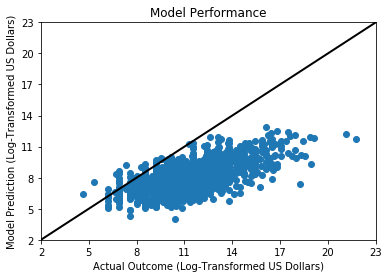

In [32]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [33]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1326  0.0713  0.1914 -0.0299 -0.1267  0.0895 -0.1151 -0.0436 -0.2101  0.1279
 0.0991 -0.0746  0.0237 -0.0933 -0.0964  0.1931 -0.1081  0.1264  0.0863 -0.0589
 0.2657 -0.1871 -0.1151 -0.0698  0.0937  0.0265  0.0347 -0.1786  0.2272 -0.0386
 0.0314  0.1820  0.1353  0.2635  0.3028 -0.1269  0.0230 -0.0600  0.0921  0.1181
 0.0389  0.1295  0.0466  0.0669  0.2113 -0.1485 -0.1113  0.1041 -0.0382 -0.2791
 0.0584  0.1641 -0.1167  0.0126  0.0411 -0.1805 -0.1051 -0.2224  0.2161  0.0341
-0.1598 -0.0790  0.1283  0.1089 -0.2054  0.0039  0.0823 -0.0008  0.1066  0.0172
 0.0734 -0.0373 -0.1415 -0.0438  0.1472  0.1722 -0.0798  0.1399 -0.0341 -0.0820
 0.1593  0.2056  0.0454 -0.0002 -0.0409  0.0915  0.0440 -0.1550  0.0795  0.1411
 0.0172  0.2078  0.0570 -0.0051 -0.1672 -0.2304  0.0412 -0.0558 -0.0760 -0.0675
-0.0749 -0.1615 -0.1703  0.1867  0.1115 -0.0095  0.1104  0.2135  0.1129  0.1452
 0.0142 -0.0246  0.2186  0.2703  0.1725 -0.0255  0.0247 -0.1095  0.0980 -0.0142
 

In [34]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.1070 -0.0907  0.1101  0.2462  0.1805 -0.0995 -0.1448  0.0939  0.1057 -0.1319

Columns 10 to 13 
 0.2161  0.1655  0.0599  0.1029
[torch.FloatTensor of size 1x14]

## Round 2: Two-Hidden-Layer Neural Network

In [35]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [36]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 1))

In [37]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 6e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

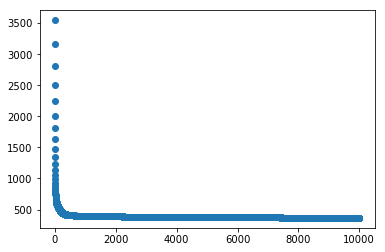

In [38]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [39]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4802)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

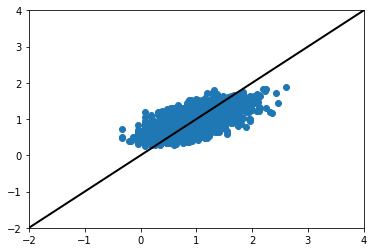

In [40]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [41]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight

In [42]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 411.4174
[torch.FloatTensor of size 1]

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1571)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

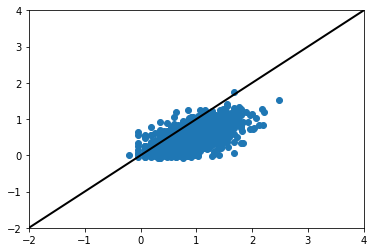

In [44]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

## Round 3: Three-Hidden-Layers Neural Network

In [45]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [46]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [47]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

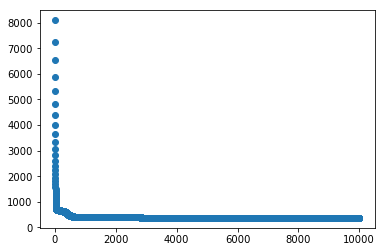

In [48]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [49]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4802)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

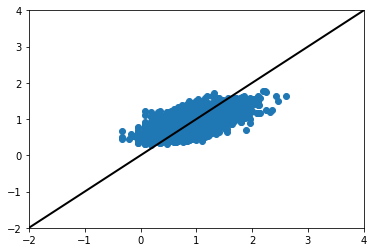

In [50]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [51]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight

In [52]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 133.8225
[torch.FloatTensor of size 1]

In [53]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1571)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

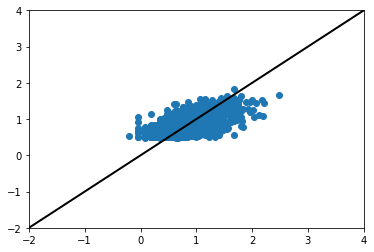

In [54]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

## Round 4: Linear Regression

In [55]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [56]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(21, 1))

In [57]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

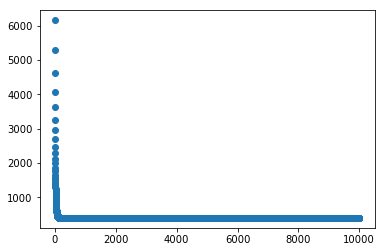

In [58]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [59]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4802)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

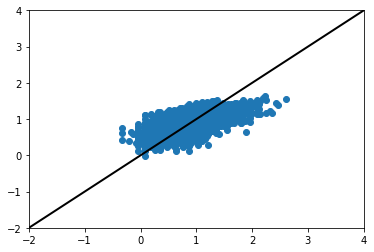

In [60]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [61]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight

In [62]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1331.3864
[torch.FloatTensor of size 1]

In [63]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1571)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

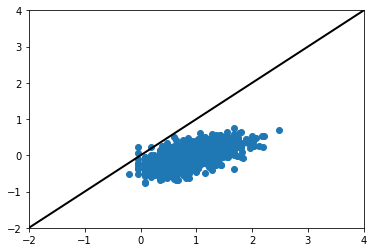

In [64]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)